# Bayesian Logistic Regression with PyMC3

In this notebook we will be using pymc3 to examine posterior probability distributions for the parameters in logistic regression for classification.

We start by importing our required libraries.

In [1]:
# This is a simple example of using pymc3 for Bayesian inference of the parameter distribution.
# written by William F Basener
# University of Virginia

import pymc3 as pm
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

We define a function that will be helpful for plotting.  This function does little mathematically, but will give us very nice trace plots.

In [2]:
def plot_traces(traces, retain=0):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:],
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

Load the data and look a the data frame.

In [3]:
data = pd.read_csv('../input/iris-flower-dataset/IRIS.csv')
data = data[['sepal_length','sepal_width','petal_length','petal_width','species']]
print(np.unique(data['species']))
data.describe()


['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [4]:
data.loc[data['species'] == 'Iris-setosa',:].mean()*10

sepal_length    50.06
sepal_width     34.18
petal_length    14.64
petal_width      2.44
dtype: float64

In [5]:
data.loc[data['species'] == 'Iris-setosa',:].cov()*10

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.242490,1.002980,0.161388,0.105469
sepal_width,1.002980,1.451796,0.116816,0.114367
petal_length,0.161388,0.116816,0.301061,0.056980
petal_width,0.105469,0.114367,0.056980,0.114939


We are using the seaborn plottng library.  This enables a very nice pairs plot for our classes.

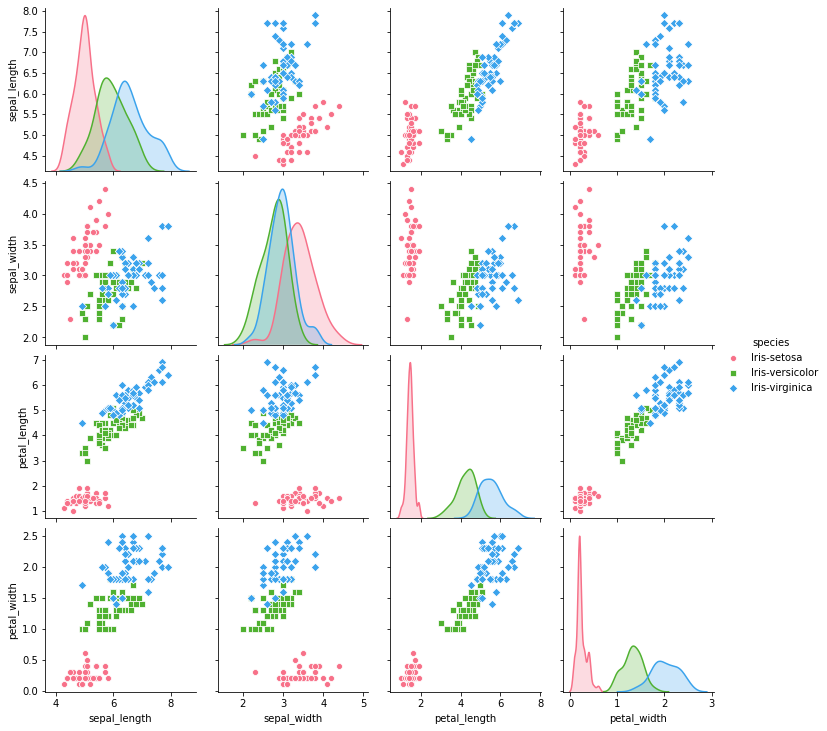

In [6]:
g = sns.pairplot(data, hue="species", palette="husl", markers=["o", "s", "D"])

Now we perform our MCMC computaiton.  With pymc3, this is very easy.  We use the usual "with" declaration for pymc3, then use glm for our logistic model and just have to specidfy the formula, the data, and the family.  The family is what tells pymc3 that this will be logistic regression.

We are going to use the default priors for GLM coefficients from PyMC3, which is $p(\theta)=N(0,10^{12}I)$.  These are very weak priors.

In [7]:
with pm.Model() as model:
    pm.glm.GLM.from_formula(formula = 'species ~ sepal_length + sepal_width + petal_length + petal_width', 
                            data = data, 
                            family = pm.glm.families.Binomial())

    trace = pm.sample(1000)

Sampling 2 chains, 154 divergences: 100%|██████████| 3000/3000 [00:51<00:00, 57.74draws/s]


Here are the variable names in the output.  

In [8]:
trace.varnames

['Intercept', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width']

Here is our nice custom traceplot using the function plot_traces we defined previously.

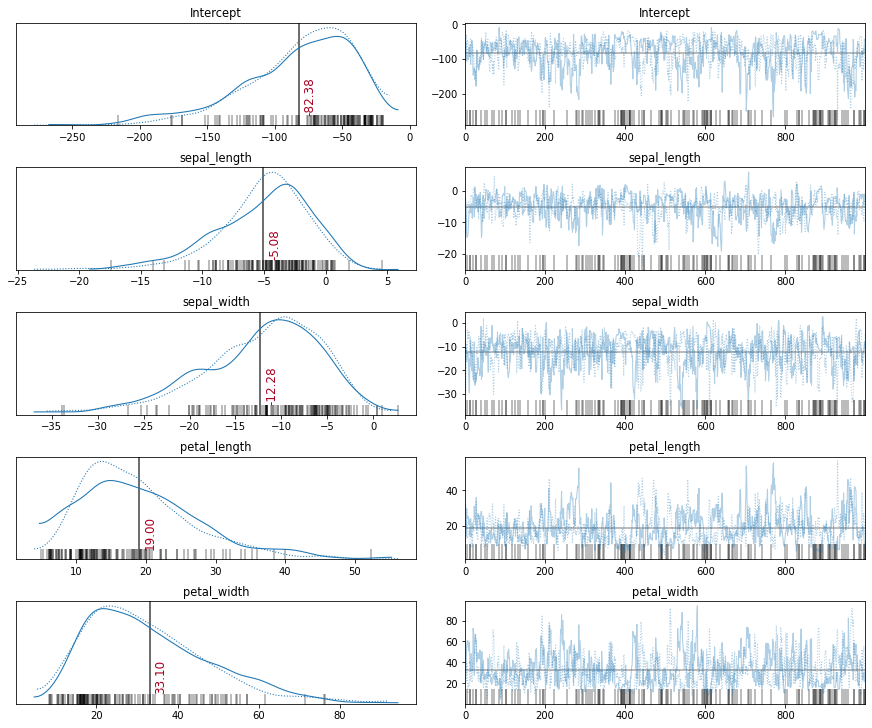

In [9]:
plot_traces(trace)

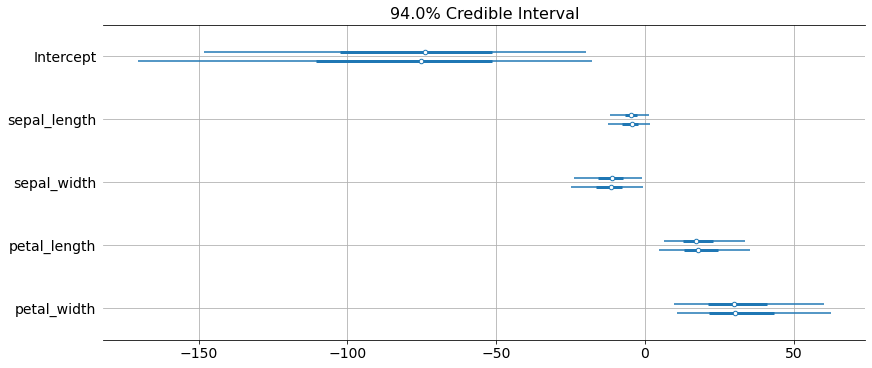

In [10]:
pm.plots.forestplot(trace, figsize=(12, 5))
# The creates a matplotlib plot, so we can modify with standard matplotlib commands
plt.grid()  # add a grid to the plot

<Figure size 648x504 with 0 Axes>

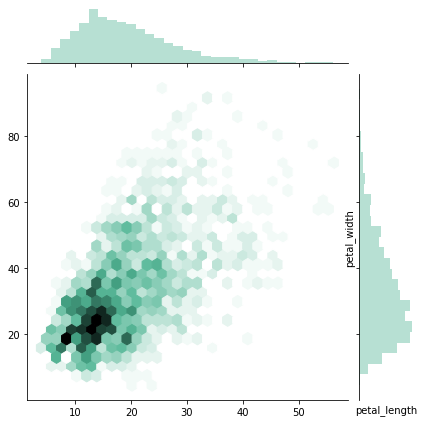

<Figure size 648x504 with 0 Axes>

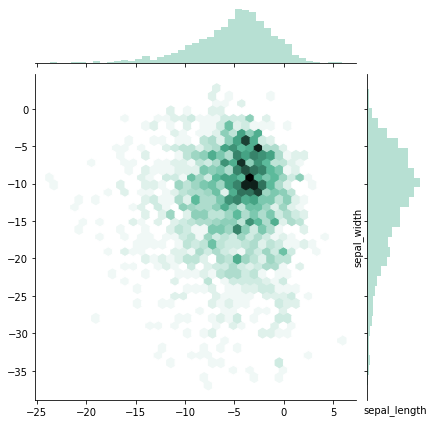

In [11]:
plt.figure(figsize=(9,7))
sns.jointplot(trace['petal_length'], trace['petal_width'], kind="hex", color="#4CB391")
plt.xlabel("petal_length")
plt.ylabel("petal_width");
plt.show()

plt.figure(figsize=(9,7))
sns.jointplot(trace['sepal_length'], trace['sepal_width'], kind="hex", color="#4CB391")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width");
plt.show()

# Part 2. Logistic Regression for Predicting Coronary Heart Disease

Now lets apply some Bayesian Regression techniques to a healthcare problem of determining risk for Coronary Heart Disease.  Logistic Regression is a great method for this problem because it provides esitmates of probability of heart disease and the Bayesian analysis provides insight into uncertainty and importance of the different predicotr variables.

In [12]:
chd_data = pd.read_csv("../input/coronary-heart-disease/CHDdata.csv")
chd_data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [13]:
chd_data.describe()

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,53.103896,26.044113,17.044394,42.816017,0.346320
std,20.496317,4.593024,2.070909,7.780699,9.817534,4.213680,24.481059,14.608956,0.476313
min,101.000000,0.000000,0.980000,6.740000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,60.000000,28.497500,23.892500,55.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,78.000000,46.580000,147.190000,64.000000,1.000000


In [14]:
# Standardize the data (mean for each numerical variable of zero, standard deviation of one.)
for key in chd_data.keys()[0:9]:
    try:
        print("Standardizing "+key+".")
        chd_data[key] = chd_data[key] - np.mean(chd_data[key])
        chd_data[key] = chd_data[key] / np.std(chd_data[key])
    except:
        print("Predictor "+key+" cannot be standardized (probably a categorical variable).")
chd_data.describe()

Standardizing sbp.
Standardizing tobacco.
Standardizing ldl.
Standardizing adiposity.
Standardizing famhist.
Predictor famhist cannot be standardized (probably a categorical variable).
Standardizing typea.
Standardizing obesity.
Standardizing alcohol.
Standardizing age.


,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,462.000000
mean,-2.571296e-16,5.022437e-16,-3.963040e-15,1.559599e-15,1.153478e-17,-5.286776e-15,-4.169344e-16,1.970526e-17,0.346320
std,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,0.476313
min,-1.823123e+00,-7.924170e-01,-1.817753e+00,-2.401708e+00,-4.089354e+00,-2.695129e+00,-6.969825e-01,-1.906103e+00,0.000000
25%,-6.997535e-01,-7.809742e-01,-7.047170e-01,-7.245926e-01,-6.224081e-01,-7.267824e-01,-6.761275e-01,-8.096968e-01,0.000000
50%,-2.113321e-01,-3.565020e-01,-1.935182e-01,9.112757e-02,-1.059418e-02,-5.680824e-02,-3.898822e-01,1.496582e-01,0.000000
75%,4.724579e-01,4.063492e-01,5.074164e-01,7.489145e-01,7.031887e-01,5.828745e-01,2.800340e-01,8.349118e-01,1.000000
max,3.891408e+00,6.007857e+00,5.119082e+00,2.197976e+00,2.538631e+00,4.878906e+00,5.321938e+00,1.451640e+00,1.000000


In [15]:
# Lets check the mean of each class to get a first look at the seperation
print("Mean for CHD Positive:")
print(np.array([chd_data[chd_data.chd == 1].mean()[0:8]]))
print("Mean for CHD Negative:")
print(np.array([chd_data[chd_data.chd == 0].mean()[0:8]]))

Mean for CHD Positive:
[[0.26426823 0.41177089 0.36139839 0.34912802 0.14172199 0.13751694
  0.0859086  0.51241433]]
Mean for CHD Negative:
[[-0.14000966 -0.21815676 -0.19146935 -0.18496849 -0.0750845  -0.07285666
  -0.04551449 -0.27147779]]


In [16]:
chd_data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.058564,1.823073,0.478412,-0.295503,Present,-0.418470,-0.176786,3.277738,0.629336,1
1,0.277089,-0.790237,-0.159680,0.412140,Absent,0.193344,0.671373,-0.612745,1.383115,1
2,-0.992806,-0.774980,-0.609245,0.884332,Present,-0.112563,0.735519,-0.541183,0.218184,0
3,1.546985,0.842264,0.807126,1.624141,Present,-0.214532,1.412621,0.295062,1.040488,1
4,-0.211332,2.171805,-0.599577,0.305351,Present,0.703189,-0.012856,1.647775,0.423760,1


Now we can build our model in PYMC3 and examine the results:

In [17]:
with pm.Model() as model:
    pm.glm.GLM.from_formula(formula = 'chd ~ sbp + tobacco + ldl + adiposity + typea + obesity + alcohol + age + famhist', 
                            data = chd_data, 
                            family = pm.glm.families.Binomial())

    #trace = pm.sample(5000) 
    approx = pm.fit(50000, method = 'advi')

Average Loss = 318.73: 100%|██████████| 50000/50000 [00:32<00:00, 1521.63it/s]


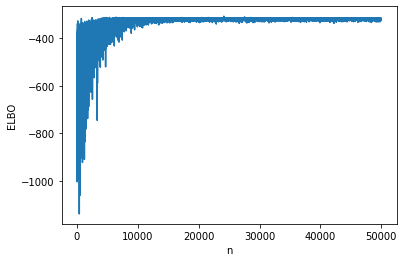

In [18]:
advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

In [19]:
trace_VI = approx.sample(draws=5000)

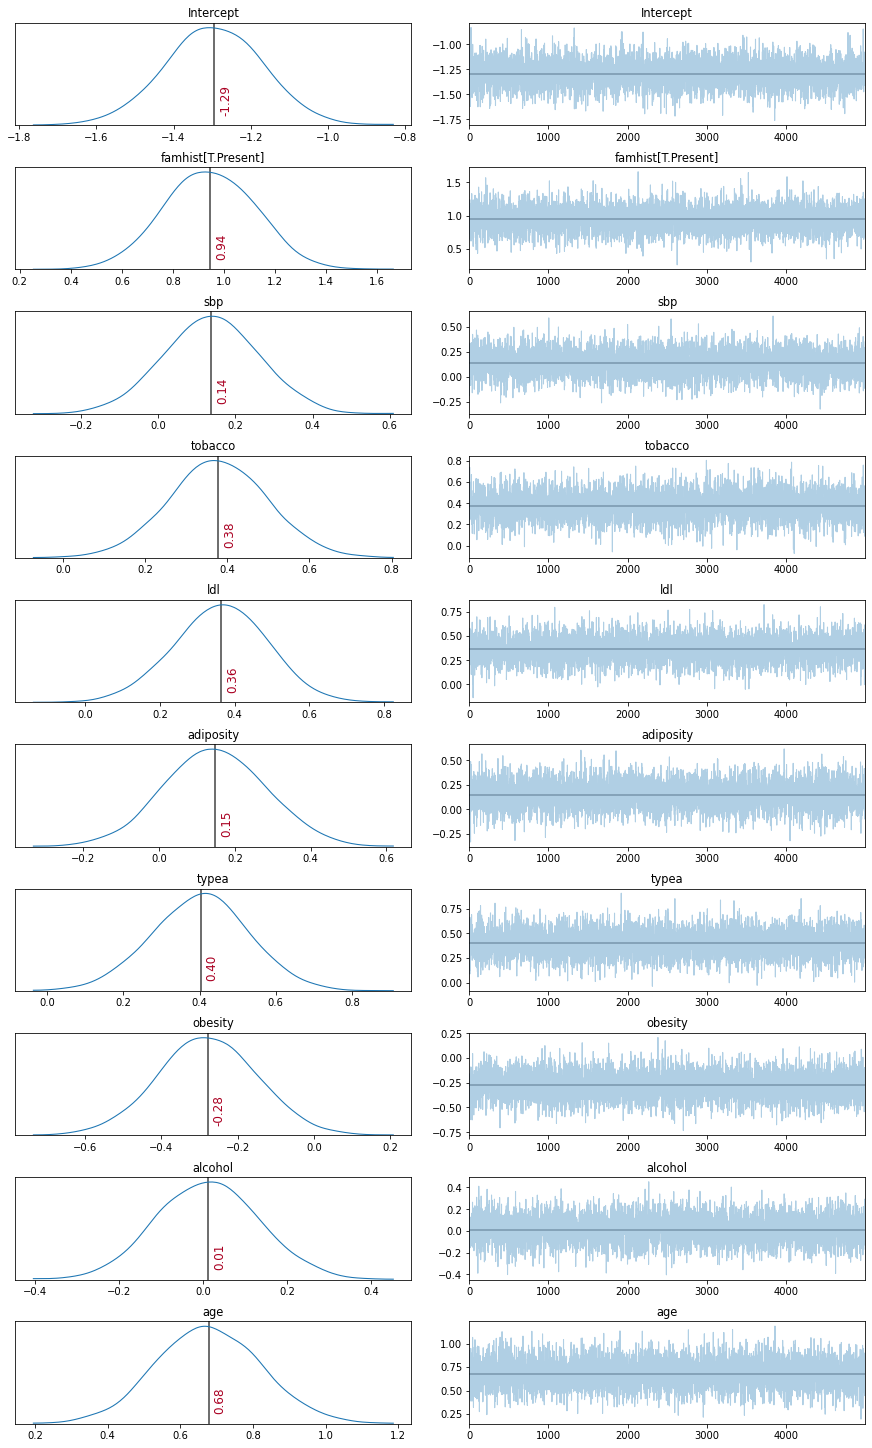

In [20]:
plot_traces(trace_VI)

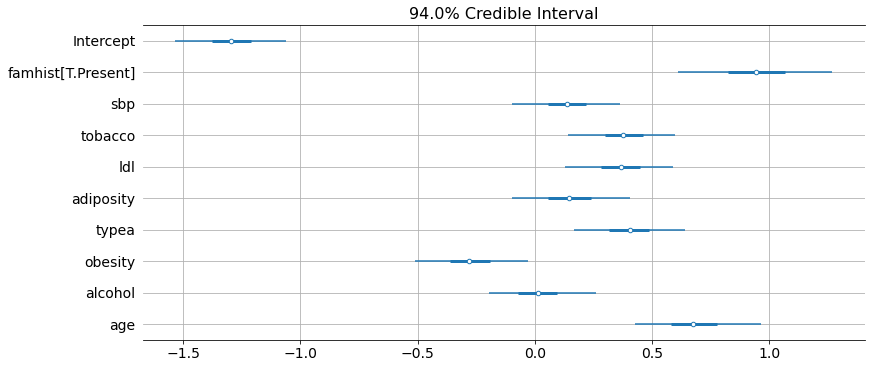

In [21]:
pm.plots.forestplot(trace_VI, figsize=(12, 5))
# The creates a matplotlib plot, so we can modify with standard matplotlib commands
plt.grid()  # add a grid to the plot

In [22]:
pm.summary(trace_VI).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.30,0.13,-1.53,-1.06,0.0,0.0,4562.0,4534.0,4574.0,4855.0,NaN
famhist[T.Present],0.94,0.18,0.61,1.27,0.0,0.0,4986.0,4981.0,4979.0,4861.0,NaN
sbp,0.14,0.12,-0.10,0.36,0.0,0.0,5168.0,5044.0,5166.0,4910.0,NaN
tobacco,0.38,0.12,0.14,0.60,0.0,0.0,5034.0,4993.0,5034.0,4982.0,NaN
ldl,0.36,0.12,0.13,0.59,0.0,0.0,4719.0,4719.0,4733.0,4791.0,NaN
adiposity,0.15,0.13,-0.10,0.41,0.0,0.0,5004.0,4999.0,5005.0,5068.0,NaN
typea,0.40,0.13,0.17,0.64,0.0,0.0,5334.0,5297.0,5339.0,4901.0,NaN
obesity,-0.28,0.13,-0.51,-0.03,0.0,0.0,4501.0,4501.0,4504.0,4453.0,NaN
alcohol,0.01,0.12,-0.20,0.26,0.0,0.0,5163.0,4446.0,5162.0,4501.0,NaN
age,0.68,0.14,0.43,0.96,0.0,0.0,4759.0,4759.0,4757.0,4570.0,NaN


In [23]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-82.38,41.04,-159.22,-17.65,2.76,1.96,221.0,221.0,214.0,437.0,1.01
sepal_length,-5.08,3.80,-12.01,1.65,0.23,0.17,272.0,245.0,305.0,321.0,1.01
sepal_width,-12.28,6.63,-24.74,-0.96,0.36,0.26,331.0,331.0,345.0,595.0,1.00
petal_length,19.00,8.35,6.02,35.27,0.62,0.44,180.0,180.0,173.0,166.0,1.01
petal_width,33.10,15.20,9.84,61.19,0.96,0.68,252.0,252.0,250.0,480.0,1.00
